## Figure 2

In [1]:
import numpy as np
import json
import itertools

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

from scipy.optimize import least_squares
import scipy.integrate as integrate

### Subplot (a) -- Theory

#### Load pre-generated network instances and calculate statistics

Download data from here:<br>
https://figshare.com/articles/dataset/Random_linear_physical_network_instances/24083532

Or generate your own networks using the `generate_randLPNs.ipynb` notebook.

In [2]:
N = 200
indep = 50
ds = np.logspace(-6,-1,20)
Mmaxs = np.zeros((indep,len(ds)))

for j,d in enumerate(ds):
    with open('saved_nets/randLPN_linklink_N%dlambda%.6findep%d.json'%(N,d,indep)) as f:
        json_dict = json.load(f)

    for i in range(indep):
        Mmaxs[i,j]=len(json_dict['physnets'][i]['links'])

#### Add theory

In [3]:
def PCubePick(l):
    if l >=0 and l <=1:
        return -l**2 * ((l-8)*l**2 + np.pi*(6*l-4))
    elif l>1 and l<=np.sqrt(2):
        return 2*l*((l**2-8*np.sqrt(l**2-1)+3)*l**2 - 4*np.sqrt(l**2-1) + 12*l**2 * np.arccos(1/l) 	 + np.pi*(3-4*l) - 0.5)
    elif l>np.sqrt(2) and l <= np.sqrt(3):
        return l*((1+l**2)*(6*np.pi + 8*np.sqrt(l**2-2)-5-l**2) - 16*l*np.arcsin(1/(np.sqrt(2-2*l**(-2)))) + 16*l*np.arctan(l*np.sqrt(l**2-2)) - 24*(l**2 + 1)*np.arctan(np.sqrt(l**2-2)))
    
    return 0.0

def Theory_Lis(N, d,res=100,logt=True,taumax=1.):
    h = N*(N-1)/2
    
    def rhs(t,L):
        RHS1, err = integrate.quad(
            lambda l: l*np.exp(-(np.pi/2*d*L[0])*l)*PCubePick(l), 0, np.sqrt(3))
        RHS2, err = integrate.quad(
            lambda l: np.exp(-(np.pi/2*d*L[0])*l)*PCubePick(l), 0, np.sqrt(3))
        return [h*RHS1,h*RHS2]
    
    if logt:
        t_eval = np.logspace(np.log10(1/h),np.log10(taumax),res)
    else:
        t_eval = np.linspace(0,taumax,res)
    t_eval[-1]=taumax #to avoid rounding errors...
    sol = integrate.solve_ivp(rhs,t_span=(0.,taumax),y0=(0.,0.),method='RK45',t_eval=t_eval)
    
    return sol.t,sol.y[0],sol.y[1]

In [4]:
theory_ds = np.logspace(-6,-1,100)
theory_Mmaxs = []
for d in theory_ds:
    ts,Ls,Ms = Theory_Lis(N, d,res=100,logt=True,taumax=1.)
    theory_Mmaxs.append(Ms[-1])

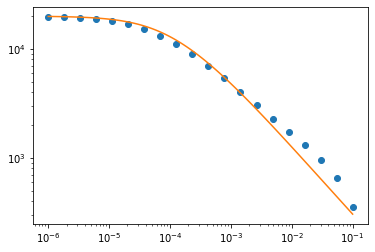

In [5]:
plt.plot(ds,Mmaxs.mean(axis=0),'o')
plt.plot(theory_ds,theory_Mmaxs)


plt.xscale('log')
plt.yscale('log')

### Subplots (b,c,d) -- Scaling with $N$

#### Load pre-generated network instances and calculate statistics

Download data from here:<br>
https://figshare.com/articles/dataset/Random_linear_physical_network_instances/24083532
Or generate your own networks using the `generate_randLPNs.ipynb` notebook.

In [6]:
alphas= [2.,1.,0.5,0.4]
indep = 10

data = {}

Ns = np.logspace(1,4,20,dtype=np.int)
for alpha in alphas:
    data[alpha] = {'N':[], 'Mmax':[], 'Mmax_std':[], 'Ltot':[], 'Ltot_std':[], 'Mphys':[], 'Mphys_std':[]}
    for N in Ns:
        try:
            with open('saved_nets/randLPN_linklink_N%dalpha%.3findep%d.json'%(N,alpha,indep)) as f:
                json_dict = json.load(f)
            bMmaxs = np.zeros(indep)
            bLtots = np.zeros(indep)
            bMphyss= np.zeros(indep)
            for i in range(indep):
                bMmaxs[i]=len(json_dict['physnets'][i]['links'])
                pts = np.array(json_dict['physnets'][i]['points'])
                vws = np.array(json_dict['physnets'][i]['links'])
                ts  = np.array(json_dict['physnets'][i]['time_added'])

                ls = np.linalg.norm(pts[vws[:,0]]-pts[vws[:,1]],axis=1)
                bLtots[i]=ls.sum()                

                bMphyss[i] = len(ts[ts<1.2*np.arange(1,len(ts)+1)]) #we have rejected a link 1/6 of the time

                
            data[alpha]['N'].append(N)
            
            
            data[alpha]['Ltot'].append(bLtots.mean())
            data[alpha]['Ltot_std'].append(1.96*bLtots.std()/np.sqrt(indep))
            
            data[alpha]['Mmax'].append(bMmaxs.mean())
            data[alpha]['Mmax_std'].append(1.96*bMmaxs.std()/np.sqrt(indep))
            
            data[alpha]['Mphys'].append(bMphyss.mean())
            data[alpha]['Mphys_std'].append(1.96*bMphyss.std()/np.sqrt(indep))
            
        except FileNotFoundError:
            pass


#### Theory

Theory predicts the scaling exponents, intercepts are fitted to simulations.

In [7]:
intercept_Mphys = {}
for alpha, values in data.items():
    x = np.array(values['N'])
    mask = x>x[int(len(x)*.8)]
    x = x[mask]
    y = np.array(values['Mphys'])[mask]
    res = least_squares(lambda a: alpha*np.log(x)+a-np.log(y), x0=N*N)
    intercept_Mphys[alpha]=res.x[0]
intercept_Mphys[0.5]

-0.879571864612304

In [8]:
intercept_Mmax = {}
for alpha, values in data.items():
    x = np.array(values['N'])
    mask = x>x[int(len(x)*.8)]
    x = x[mask]
    y = np.array(values['Mmax'])[mask]
    res = least_squares(lambda a: (3*alpha+4)/5*np.log(x)+a-np.log(y), x0=N*N)
    intercept_Mmax[alpha]=res.x[0]
intercept_Mmax[0.5]

0.37250035389714736

In [9]:
intercept_Ltot = {}
for alpha, values in data.items():
    x = np.array(values['N'])
    mask = x>x[int(len(x)*.8)]
    x = x[mask]
    y = np.array(values['Ltot'])[mask]
    res = least_squares(lambda a: (4*alpha+2)/5*np.log(x)+a-np.log(y), x0=N*N)
    intercept_Ltot[alpha]=res.x[0]
intercept_Ltot[0.5]

0.9319067707691341

### Final figure

In [10]:
norm = Normalize(vmin=1/3, vmax=2.)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='rainbow')

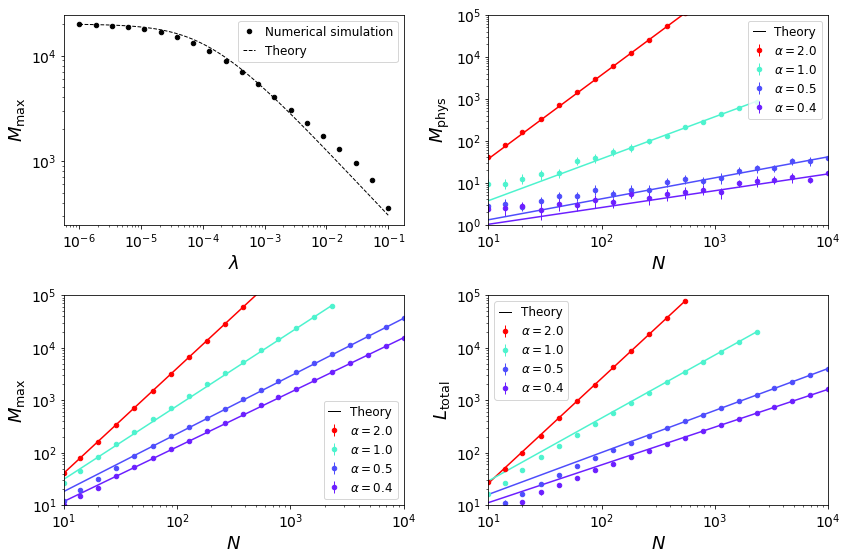

In [11]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(12,8))#,constrained_layout=True)

gs = plt.GridSpec(2, 2, figure=fig)
axs = [fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1]),
      fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])]

lw=1
lw2=1.5
ps = 4.5
lfs = 18


plt.sca(axs[0])
plt.plot(ds,Mmaxs.mean(axis=0),'ko',markersize=ps, label='Numerical simulation')
plt.plot(theory_ds,theory_Mmaxs,'k--', label=r'Theory',linewidth=1)


plt.legend(handlelength=1,fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$',fontsize=lfs)
plt.ylabel(r'$M_{\mathrm{max}}$',fontsize=lfs)

plt.sca(axs[1])

for alpha, values in data.items():
    c = cmap.to_rgba(alpha)
    plt.errorbar(values['N'],values['Mphys'],values['Mphys_std'],fmt='o',
                 color=c,
                 label=r'$\alpha=$%.1f'%alpha,linewidth=lw,markersize=ps)
    

plt.gca().set_prop_cycle(None)    
for alpha,values in data.items():
    c = cmap.to_rgba(alpha)
    x = np.array(values['N'])
    plt.plot(x,np.exp(intercept_Mphys[alpha])*x**alpha,
             '-',color=c,linewidth=lw2)

plt.plot([1,2],'k-',label='Theory',linewidth=lw)

plt.ylim(bottom=1,top=1e5)
plt.xlim(left=10,right=10000)
plt.legend(handlelength=1,fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N$',fontsize=lfs)
plt.ylabel(r'$M_{\mathrm{phys}}$',fontsize=lfs)

plt.sca(axs[2])

for alpha, values in data.items():
    c = cmap.to_rgba(alpha)
    plt.errorbar(values['N'],values['Mmax'],values['Mmax_std'],
                 fmt='o',color=c,label=r'$\alpha=$%.1f'%alpha,linewidth=lw,markersize=ps)
    

plt.gca().set_prop_cycle(None)    
for alpha,values in data.items():
    c = cmap.to_rgba(alpha)
    x = np.array(values['N'])
    plt.plot(x,np.exp(intercept_Mmax[alpha])*x**((3*alpha+4)/5),
             '-',color=c,linewidth=lw2)

plt.plot([1,2],'k-',label='Theory',linewidth=lw)

plt.ylim(bottom=10,top=1e5)
plt.xlim(left=10,right=10000)
plt.legend(handlelength=1,fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N$',fontsize=lfs)
plt.ylabel(r'$M_{\mathrm{max}}$',fontsize=lfs)

plt.sca(axs[3])

for alpha, values in data.items():
    c = cmap.to_rgba(alpha)
    plt.errorbar(values['N'],values['Ltot'],yerr=values['Ltot_std'],
                 fmt='o',color=c,label=r'$\alpha=$%.1f'%alpha,linewidth=lw,markersize=ps)

plt.gca().set_prop_cycle(None)    
for alpha,values in data.items():
    c = cmap.to_rgba(alpha)
    x = np.array(values['N'])
    plt.plot(x,np.exp(intercept_Ltot[alpha])*x**((4*alpha+2)/5),
             '-',color=c,linewidth=lw2)

plt.plot([1,2],'k-',label='Theory',linewidth=lw)

plt.ylim(bottom=10,top=1e5)
plt.xlim(left=10,right=10000)
plt.legend(handlelength=1,fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N$',fontsize=lfs)
plt.ylabel(r'$L_{\mathrm{total}}$',fontsize=lfs)

plt.tight_layout()